In [8]:
!conda install -c conda-forge pymc>=4

^C

CondaError: KeyboardInterrupt



In [9]:
import numpy as np 
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
import os
from pathlib import Path
from scipy.io import loadmat 
from multiprocessing import Pool 
import time 
# from numba import cuda

The code uses parallelism to run fitting on different rows concurretly. During the process of fitting an row, the fitting result of the previous voxel will be
cached to initialize the next voxel, this can significantly accelerate the fitting. 


In [10]:
# define the t1 mapping model - this is for inverted data already
def model_t1(theta,x):
    # theta is composed of A, B, T1
    return theta[0] - theta[1]*np.exp(-1*x*(theta[1]/theta[0] - 1)/theta[2])


# define the derivative (Jacobian)
def jac(theta, x , y):
    J = np.empty((x.size, theta.size))
    term_share = np.exp(-x*(theta[1]/theta[0]-1)/theta[2])
    J[:, 0] = 1 - theta[1]*term_share*(x*theta[1]/(theta[2]*theta[0]**2))
    J[:, 1] = -1*term_share+theta[1]*term_share*(x/(theta[0]*theta[2]))
    J[:, 2] = -1*theta[1]*term_share*(x*(theta[1]/theta[0] -1 )/theta[2]**2)
    return J
    
# and Hessian approximation
def Hessian(jac, theta, x, y, mad):
  D = np.zeros([3,3])
  J = jac(theta,x,y)
  for i in range(D.shape[0]):
    for j in range(D.shape[1]):
      D[i,j] = np.multiply(J[:,i],J[:,j]).sum()
  return D/(mad**2)


def sd_calculation(p_opt, tvec, signal_invert):
  theta_opt = np.array([p_opt[0], p_opt[1]*p_opt[0], p_opt[2]])
  residuals = np.abs(model_t1(theta_opt, tvec)- signal_invert)
  
  residuals.sort()
  mad = np.median(residuals[2:])/0.6745
  D = Hessian(jac, theta_opt,tvec,signal_invert, mad)
  C = np.linalg.pinv(D)
  T1_sd_ls = np.sqrt(C[2,2])
  return T1_sd_ls

In [11]:
def wall_clock_timing(func, *args, **kwargs):
    '''
    decorator that computes the wall clock running time 
    '''
    def timing_func(*args, **kwargs):
        start = time.time()
        ret = func(*args, **kwargs)
        end = time.time()
        print(f"Time elapsed: {end - start:.3f} seconds")
        return ret 
    return timing_func


def T1_3param(t, C, k, T1):
    '''
    MOLLI signal acquistion equation s(t) = C(1 - k * np.exp(-t*(k-1)/T1))
    '''
    return C*(1 - k * np.exp(-t*(k-1)/T1))


def polarity_recovery(signal, tvec, p0=None, signal_threshold=25,
                      cache=None, cache_result=True,
                      **kwargs):
    '''
    Polarity recovery fitting, using cache can achieve an acceleration factor
    of ~2. 

    Parameters
    ----------
    signal : numpy.array
        signal acquisition array of shape (#acquisitions, )
    tvec : numpy.array
        inverstion time array of shape (#acquisitions, )
    signal_threshold : float
        threshold of maximal signal intensity, no protons will be assumed if max(signal) < threshold
    cache : List[dict]
        List of cached polarity recovery fitting results, for example results
        from the neignbouring voxels.
    cache_result : bool
        if the fitting intermediate results should be cached
    **kwargs 
        parameters that can be passed to curve fit
    
    '''
    # make safe code 
    signal = signal.squeeze().astype(np.float64)
    tvec = tvec.squeeze().astype(np.float64)
    
    # a few checks before running
    assert np.all(tvec[1:] - tvec[:-1] >= -1e-8), "Time vector is not sorted!"
    assert signal.shape == tvec.shape, "signal and tvec have mismatching shape!"
    
    # early exit 
    if signal.max() < signal_threshold: 
        return dict(p_opt=np.array([1., 0., 0.]), p_cov=None,
                    null_index=0, sd = 0, cache=None)
    
    # adaptively initialize p0 
    if p0 is None:
        p0 = np.array([signal.max(), 2.0, 1e3])
    if cache is None:
        cache = [dict(p_opt=p0) for _ in tvec]
    assert len(cache) == tvec.shape[0], "cache has incorrect shape!"
    
    opt_results = []
    fitting_errors = [] 
    
    # polarity recovery 
    for null_index in range(signal.shape[-1]):
        signal_inverted = signal.copy()    #copy the array to avoid in-place change
        signal_inverted[:null_index] *= -1
        try:
            # ensure p0 is valid
            p0 = cache[null_index]["p_opt"]
            if kwargs.get("bounds") is not None:
                p0 = np.clip(p0, kwargs['bounds'][0], kwargs['bounds'][1])
            
            # optimize!
            p_opt, p_cov  = curve_fit(T1_3param, tvec, signal_inverted,
                                      p0=p0,
                                      **kwargs)
            
            # evaluate the mse error
            signal_fitted = T1_3param(tvec, *p_opt)
            mse = np.mean((signal_fitted - signal_inverted) ** 2)
        except Exception as e:
            print(cache[null_index]["p_opt"])
            print(kwargs)
            # handle the exception and indicate when the error is raised
            raise type(e)(str(e) + f"\nError raised when null_index={null_index:d}") 
       
        # save intermediate fitting results 
        opt_results.append(dict(p_opt=p_opt,
                                p_cov=p_cov,
                                mse=mse))
        fitting_errors.append(mse) 

    # find the best one
    best_null_index = np.argmin(fitting_errors) 
    best_opt_result = opt_results[best_null_index]
    best_opt_result["null_index"] = best_null_index

    signal_invert = signal.copy()
    signal[:best_null_index] = -1*signal[:best_null_index]
    best_opt_result['sd'] = sd_calculation(best_opt_result['p_opt'], tvec, signal_invert)
    # cache results if necessary 
    best_opt_result["cache"] = opt_results if cache_result else None 
    return best_opt_result


def split_volume(volume):
    '''
    build a generator that yields a row of volume at each call 
    
    Parameters
    ----------
    volume : numpy.array
        volume to be splited with shape [height, width, ...]
    '''
    for i in range(volume.shape[0]):
        yield volume[i, ...]


def fit_volume_row(signal_row, tvec, do_fitting_mask=None):
#     raise Exception("I am just crazy")
    '''
    fit a row of the volume
    
    Parameters
    ----------
    signal_row : numpy.array
        signal array with shape (width, #signal acquisitions)
    tvec : numpy.array
        inversion time vector with shape (#signal acquisitions, )
    do_fitting_mask : Union[None, numpy.array]
        per voxel tag indicating if fitting should be performed.
    '''
    if do_fitting_mask is None:
        do_fitting_mask = np.zeros(tvec.shape, dtype=bool)
    do_fitting_mask = np.squeeze(do_fitting_mask)
    
    # check the parameters first
    assert signal_row.shape[-1] == tvec.shape[-1], "Shape mismatch!"
    assert np.ndim(signal_row) == 2, "Please only pass a row of signal!"
    assert do_fitting_mask.shape == (signal_row.shape[0], ), "Fitting mask shape incorrect! " + str(do_fitting_mask.shape) 
    
    # initialize fitting result
    parameter_row = np.zeros((signal_row.shape[0], 3)) # 3 for A, B, T1*
    null_index_row = np.zeros((signal_row.shape[0], ))
    sd_row = np.zeros((signal_row.shape[0], ))

    # sort tvec
    order = np.argsort(tvec)
    tvec_sorted = tvec[order]
    signal_row_sorted = signal_row[..., order]
    
    # go through all voxels in a row
    cached = None
    for i in range(signal_row.shape[0]):
        if do_fitting_mask[i]:
            signal_sorted = signal_row_sorted[i, ...]
            # cached = fit_result["cache"] if i > 0  else None
            fit_result = polarity_recovery(signal_sorted, tvec_sorted,
                                           cache=cached,
                                           method="trf",
                                           bounds=(0, (signal_sorted.max() * 4., 15., 5e3)), # 0 < A < max(s) * 4, 0 < B < max(s) * 8, 0 < T1 < 5000
                                           max_nfev=5000)
            cached = fit_result["cache"]
            parameter_row[i, ...] = fit_result["p_opt"]
            null_index_row[i] = fit_result['null_index']
            sd_row[i] = fit_result["sd"]
        else:
            parameter_row[i, ...] = np.nan
            null_index_row[i] = np.nan
            sd_row[i] = np.nan
    return dict(p_opt=parameter_row, null_index=null_index_row, sd = sd_row)


#@wall_clock_timing
def polarity_recovery_volume(volume, tvec, do_fitting_mask=None, pool=None):
    '''
    Parallel fitting the whole volume,the row-wise fitting will take place in parallel
    if ``n_processes > 1``.
    
    Parameters
    ----------
    volume : numpy.array
        signal acquistion to be fitted of shape (height, width, #acquistions)
    tvec : numpy.array
        inversion time array of shape (#acquisitions,)
    do_fitting_mask : numpy.array
        bool array of shape (height, width) indicating if the fitting routine will be performed on a certain voxel
    pool : Pool 
        process pool for parallel fitting
    '''
    if do_fitting_mask is None:
        do_fitting_mask = np.ones(volume.shape[:2], dtype=bool)
        
    # check parameters
    assert np.ndim(volume) == 3, "Please pass volumes with shape (height, width, #acquisitions)"
    assert volume.shape[-1] == tvec.squeeze().shape[0], "Volume and tvec have mismatching shape!"
    assert do_fitting_mask.shape == volume.shape[:2], "do_fitting_mask has incorrect shape!"
        
    # start pool and run fitting per row
    if pool is None:
        print('start fitting.')
        # use single process only
        results_per_row = map(fit_volume_row, 
                              split_volume(volume),
                              (tvec for _ in range(volume.shape[0])),
                              split_volume(do_fitting_mask)
                             )
    else:
        # use multiple processes 
        results_per_row = pool.starmap(fit_volume_row,
                                       zip(split_volume(volume),
                                           (tvec for _ in range(volume.shape[0])),
                                           split_volume(do_fitting_mask)
                                          )
                                      )
    
    # assembly results per row
    parameter_estimated, null_index, sd = zip(*(
        (res["p_opt"], res["null_index"], res["sd"]) for res in results_per_row))
    parameter_estimated = np.stack(parameter_estimated, axis=0)
    null_index = np.stack(null_index, axis=0)
    sd = np.stack(sd, axis=0)
    
    return dict(p_opt=parameter_estimated, null_index=null_index, sd = sd)

In [12]:
def loadmat_wrapper(data_path):
    '''
    A simple encapsulation of loadmat and data retrieval
    '''
    dat = loadmat(data_path) 
    pmap_mse = dat["pmap_mse"]
    volume = dat["data"][0][0][0]
    tvec = dat["data"][0][0][1].squeeze()
    null_index = dat["null_index"]
    return dict(volume=volume,
                tvec=tvec,
                pmap_mse=pmap_mse,
                null_index=null_index
               )

In [13]:
def loadmat_wrapper_Yi(data_path):
    '''
    A simple encapsulation of loadmat and data retrieval for MOLLI4Yi dataset - consider only v and tvec
    '''
    dat = loadmat(data_path) 
    # pmap_mse = dat["pmap_mse"]
    volume = dat["v"][160:285,145:270,1,:]
    tvec = dat["tvec"][0]
    #null_index = dat["null_index"]
    return dict(volume=volume,
                tvec=tvec,
                # pmap_mse=pmap_mse,
                # null_index=null_index
               )

In [17]:
dat = loadmat('MAVI102_20151026_pre1.mat') 

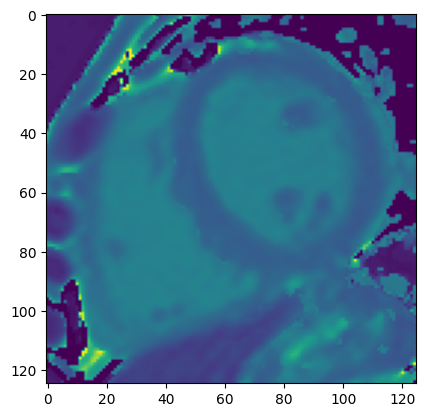

In [18]:
plt.imshow(dat['T1'][160:285,145:270,1])

## experimental: taking a sample point in the image

(-0.5, 431.5, 431.5, -0.5)

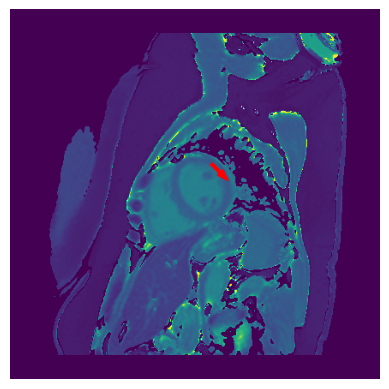

In [19]:
plt.imshow(dat['T1'][:,:,1])
plt.arrow(255-20,200-20,10,10,width = 3, color = 'r')
plt.axis('off')

In [20]:
y = np.float64(dat['v'][200,255,2,:].copy())
yr = np.float64(dat['vr'][200,255,2,:].copy())
x = np.float64(dat['tvec'][2].copy())
inds = x.argsort()
x.sort()
y = y[inds]
yr = yr[inds]

array([ 114.,  232.,  350., 1155., 1249., 1350., 2185., 2273., 2325.,
       3289., 4255.])

In [21]:
res = polarity_recovery(yr, x, p0=None, signal_threshold=25,
                      cache=None, cache_result=True, method="trf",
                                           bounds=(0, (y.max() * 4., 15., 5e3)), # 0 < A < max(s) * 4, 0 < B < max(s) * 8, 0 < T1 < 5000
                                           max_nfev=5000)

p_opt = res['p_opt']
null_index = res['null_index']

In [ ]:
p_cov = res['p_cov']

In [ ]:
np.sqrt(p_cov[2,2])

57.542566161263366

In [ ]:
p_opt

array([ 277.98927544,    2.29157083, 1561.74398223])

## calculating SD using inverted signals

In [ ]:
y_invert = y.copy()
if not np.isnan(null_index):
    y_invert[:null_index] = -1*y[:null_index]

In [ ]:
# define the t1 mapping model - this is for inverted data already
def model(theta,x):
    # theta is composed of A, B, T1
    return theta[0] - theta[1]*np.exp(-1*x*(theta[1]/theta[0] - 1)/theta[2])


# define the derivative (Jacobian)
def jac(theta, x , y):
    J = np.empty((x.size, theta.size))
    term_share = np.exp(-x*(theta[1]/theta[0]-1)/theta[2])
    J[:, 0] = 1 - theta[1]*term_share*(x*theta[1]/(theta[2]*theta[0]**2))
    J[:, 1] = -1*term_share+theta[1]*term_share*(x/(theta[0]*theta[2]))
    J[:, 2] = -1*theta[1]*term_share*(x*(theta[1]/theta[0] -1 )/theta[2]**2)

    return J
    
# and Hessian approximation
def Hessian(jac, theta, x, y, mad):
  D = np.zeros([3,3])
  J = jac(theta,x,y)
  for i in range(D.shape[0]):
    for j in range(D.shape[1]):
      D[i,j] = np.multiply(J[:,i],J[:,j]).sum()
  return D/(mad**2)
  
theta_opt = np.array([p_opt[0], p_opt[1]*p_opt[0], p_opt[2]])
print(theta_opt)
residuals = np.abs(model(theta_opt, x)- y_invert)
residuals.sort()
mad = np.median(residuals[2:])/0.6745
print(f'MAD estimation is {mad}')
D = Hessian(jac, theta_opt,x,y_invert, mad)
C = np.linalg.inv(D)
T1_sd_ls = np.sqrt(C[2,2])
print(C)
# notice here the (3,3) entry is the sigma of T1 by calculation
print(f'estimated T1 SD is {np.sqrt(C[2,2])}' )

[ 277.98927544  637.03211435 1561.74398223]
MAD estimation is 15.176536751665296
[[ 243.89135838  154.98594111 -114.43891911]
 [ 154.98594111  256.51075569  159.34397328]
 [-114.43891911  159.34397328 2179.41297917]]
estimated T1 SD is 46.68418339404402


In [ ]:
x_plot = np.linspace(x.min(), x.max(), 30)
y_plot = T1_3param(x_plot, p_opt[0], p_opt[1],p_opt[2])
y_invert = y.copy()
if not np.isnan(null_index):
    y_invert[:null_index] = -1*y[:null_index]

In [ ]:
x_to_append = np.float64([920,925,950])
y_to_append = T1_3param(x_to_append, p_opt[0], p_opt[1],p_opt[2])+40*np.random.randn(3)
y_to_append


array([ 39.91088705, -62.22292241, -26.43138774])

In [ ]:
x_zero = np.append(x,x_to_append)
y_zero = np.append(y_invert,y_to_append)

In [ ]:
inds = x_zero.argsort()
x_zero.sort()
y_zero = y_zero[inds]
y_zero_abs = np.abs(y_zero)

In [ ]:
res_zero = polarity_recovery(y_zero, x_zero, p0=None, signal_threshold=25,
                      cache=None, cache_result=True, method="trf",
                                           bounds=(0, (y.max() * 4., 15., 5e3)), # 0 < A < max(s) * 4, 0 < B < max(s) * 8, 0 < T1 < 5000
                                           max_nfev=5000)

p_opt_zero = res_zero['p_opt']
null_index_zero = res_zero['null_index']
x_zero_plot = np.linspace(x.min(), x.max(), 30)
y_zero_plot = T1_3param(x_plot, p_opt_zero[0], p_opt_zero[1],p_opt_zero[2])
y_zero_invert = y_zero.copy()
if not np.isnan(null_index_zero):
    y_zero_invert[:null_index_zero] = -1*y_zero[:null_index_zero]

In [ ]:
res_zero_abs = polarity_recovery(y_zero_abs, x_zero, p0=None, signal_threshold=25,
                      cache=None, cache_result=True, method="trf",
                                           bounds=(0, (y.max() * 4., 15., 5e3)), # 0 < A < max(s) * 4, 0 < B < max(s) * 8, 0 < T1 < 5000
                                           max_nfev=5000)

p_opt_zero_abs = res_zero_abs['p_opt']
null_index_zero_abs = res_zero_abs['null_index']
x_zero_abs_plot = np.linspace(x.min(), x.max(), 30)
y_zero_abs_plot = T1_3param(x_plot, p_opt_zero_abs[0], p_opt_zero_abs[1],p_opt_zero_abs[2])
y_zero_abs_invert = y_zero_abs.copy()
if not np.isnan(null_index_zero):
    y_zero_abs_invert[:null_index_zero_abs] = -1*y_zero_abs[:null_index_zero_abs]

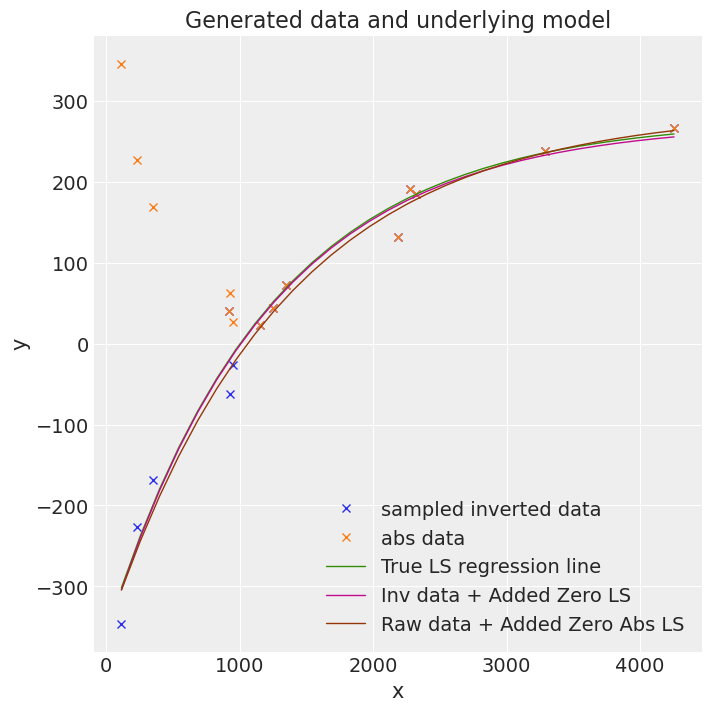

In [ ]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_zero, y_zero, "x", label="sampled inverted data")
ax.plot(x_zero, y_zero_abs, "x", label="abs data")

ax.plot(x_plot, y_plot, label="True LS regression line", lw=1.0)
ax.plot(x_zero_plot, y_zero_plot, label="Inv data + Added Zero LS", lw=1.0)
ax.plot(x_zero_abs_plot, y_zero_abs_plot, label="Raw data + Added Zero Abs LS", lw=1.0)
plt.legend(loc=0)

# Bayesian Fitting

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample, Uniform, InverseGamma, StudentT

az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.1


As mentioned in this thread, standardization of data is recommended as it can speed up the MCMC process...

https://stats.stackexchange.com/questions/273123/mcmc-bayesian-approach-centering-and-standardizing

## With normalization for MC

In [ ]:
# now with x and y normalized
x_norm = x_zero/200
y_norm = y_zero_abs/100
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors, here T1 is also scaled down with the same mutiplier of x_norm
    T1_mu = Uniform('T1_mu', 1,10)
    sigma = InverseGamma("sigma", 0.001,0.001)
    C = Uniform("C", lower = 0.1, upper = 5)
    k = Uniform("k", lower = 1, upper = 3)
    T1 = Normal("T1", T1_mu, sigma = 0.2)
    
    
    # Define likelihood
    likelihood = Normal("y", mu=np.abs(C*(1 - k*np.exp(-1*x_norm*(k - 1)/T1))), sigma=sigma, observed=y_norm)

    # Inference!
    # draw 2000 posterior samples using NUTS sampling
    idata = sample(tune = 1500, draws = 1000, chains = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [T1_mu, sigma, C, k, T1]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 30 seconds.


array([[<AxesSubplot: title={'center': 'T1'}>,
        <AxesSubplot: title={'center': 'T1'}>],
       [<AxesSubplot: title={'center': 'T1_mu'}>,
        <AxesSubplot: title={'center': 'T1_mu'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>],
       [<AxesSubplot: title={'center': 'C'}>,
        <AxesSubplot: title={'center': 'C'}>],
       [<AxesSubplot: title={'center': 'k'}>,
        <AxesSubplot: title={'center': 'k'}>]], dtype=object)

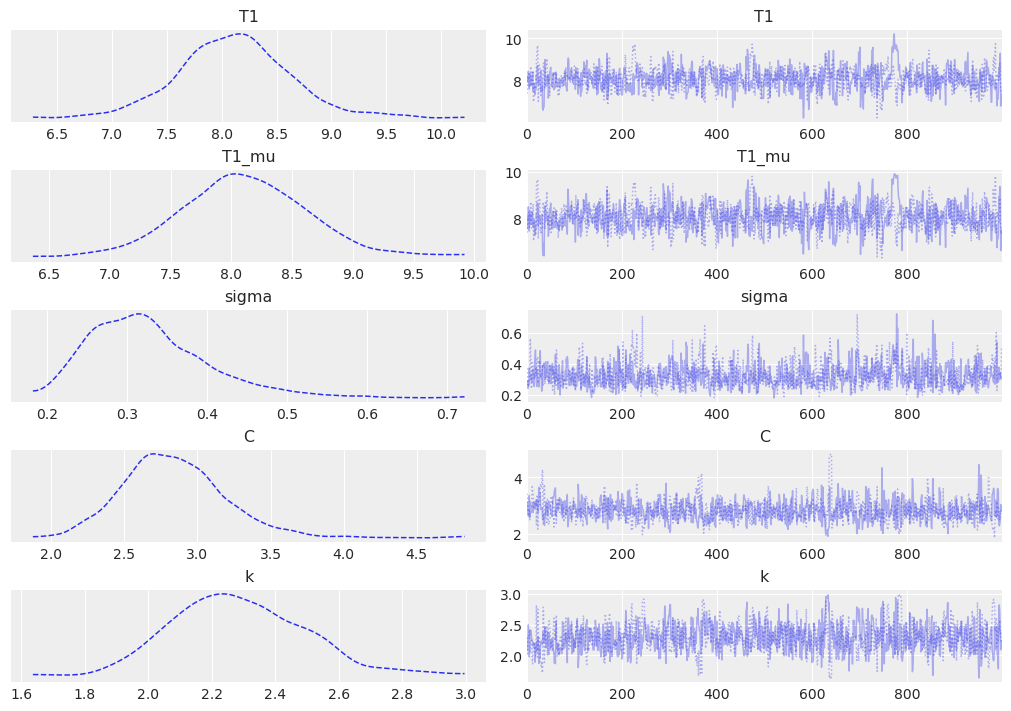

In [ ]:
az.plot_trace(idata, figsize=(10, 7), combined = True)

In [ ]:
print(idata['posterior']['T1'].mean(), idata['posterior']['T1'].std())
print(200 * idata['posterior']['T1'].mean(), 200* idata['posterior']['T1'].std())

<xarray.DataArray 'T1' ()>
array(8.11182439) <xarray.DataArray 'T1' ()>
array(0.50684661)
<xarray.DataArray 'T1' ()>
array(1622.36487788) <xarray.DataArray 'T1' ()>
array(101.36932126)


In [ ]:
print(200 * idata['posterior']['T1'].mean(), 200* idata['posterior']['T1'].std())

<xarray.DataArray 'T1' ()>
array(1622.36487788) <xarray.DataArray 'T1' ()>
array(101.36932126)


In [ ]:
print(T1_sd_ls,p_opt[2])

46.68418339404402 1561.7439822294398


In [ ]:
p_bayes = np.array ([200*idata['posterior']['T1'].mean(),100*idata['posterior']['C'].mean(),idata['posterior']['k'].mean()])
p_bayes

array([1622.36487788,  284.20904096,    2.28934269])

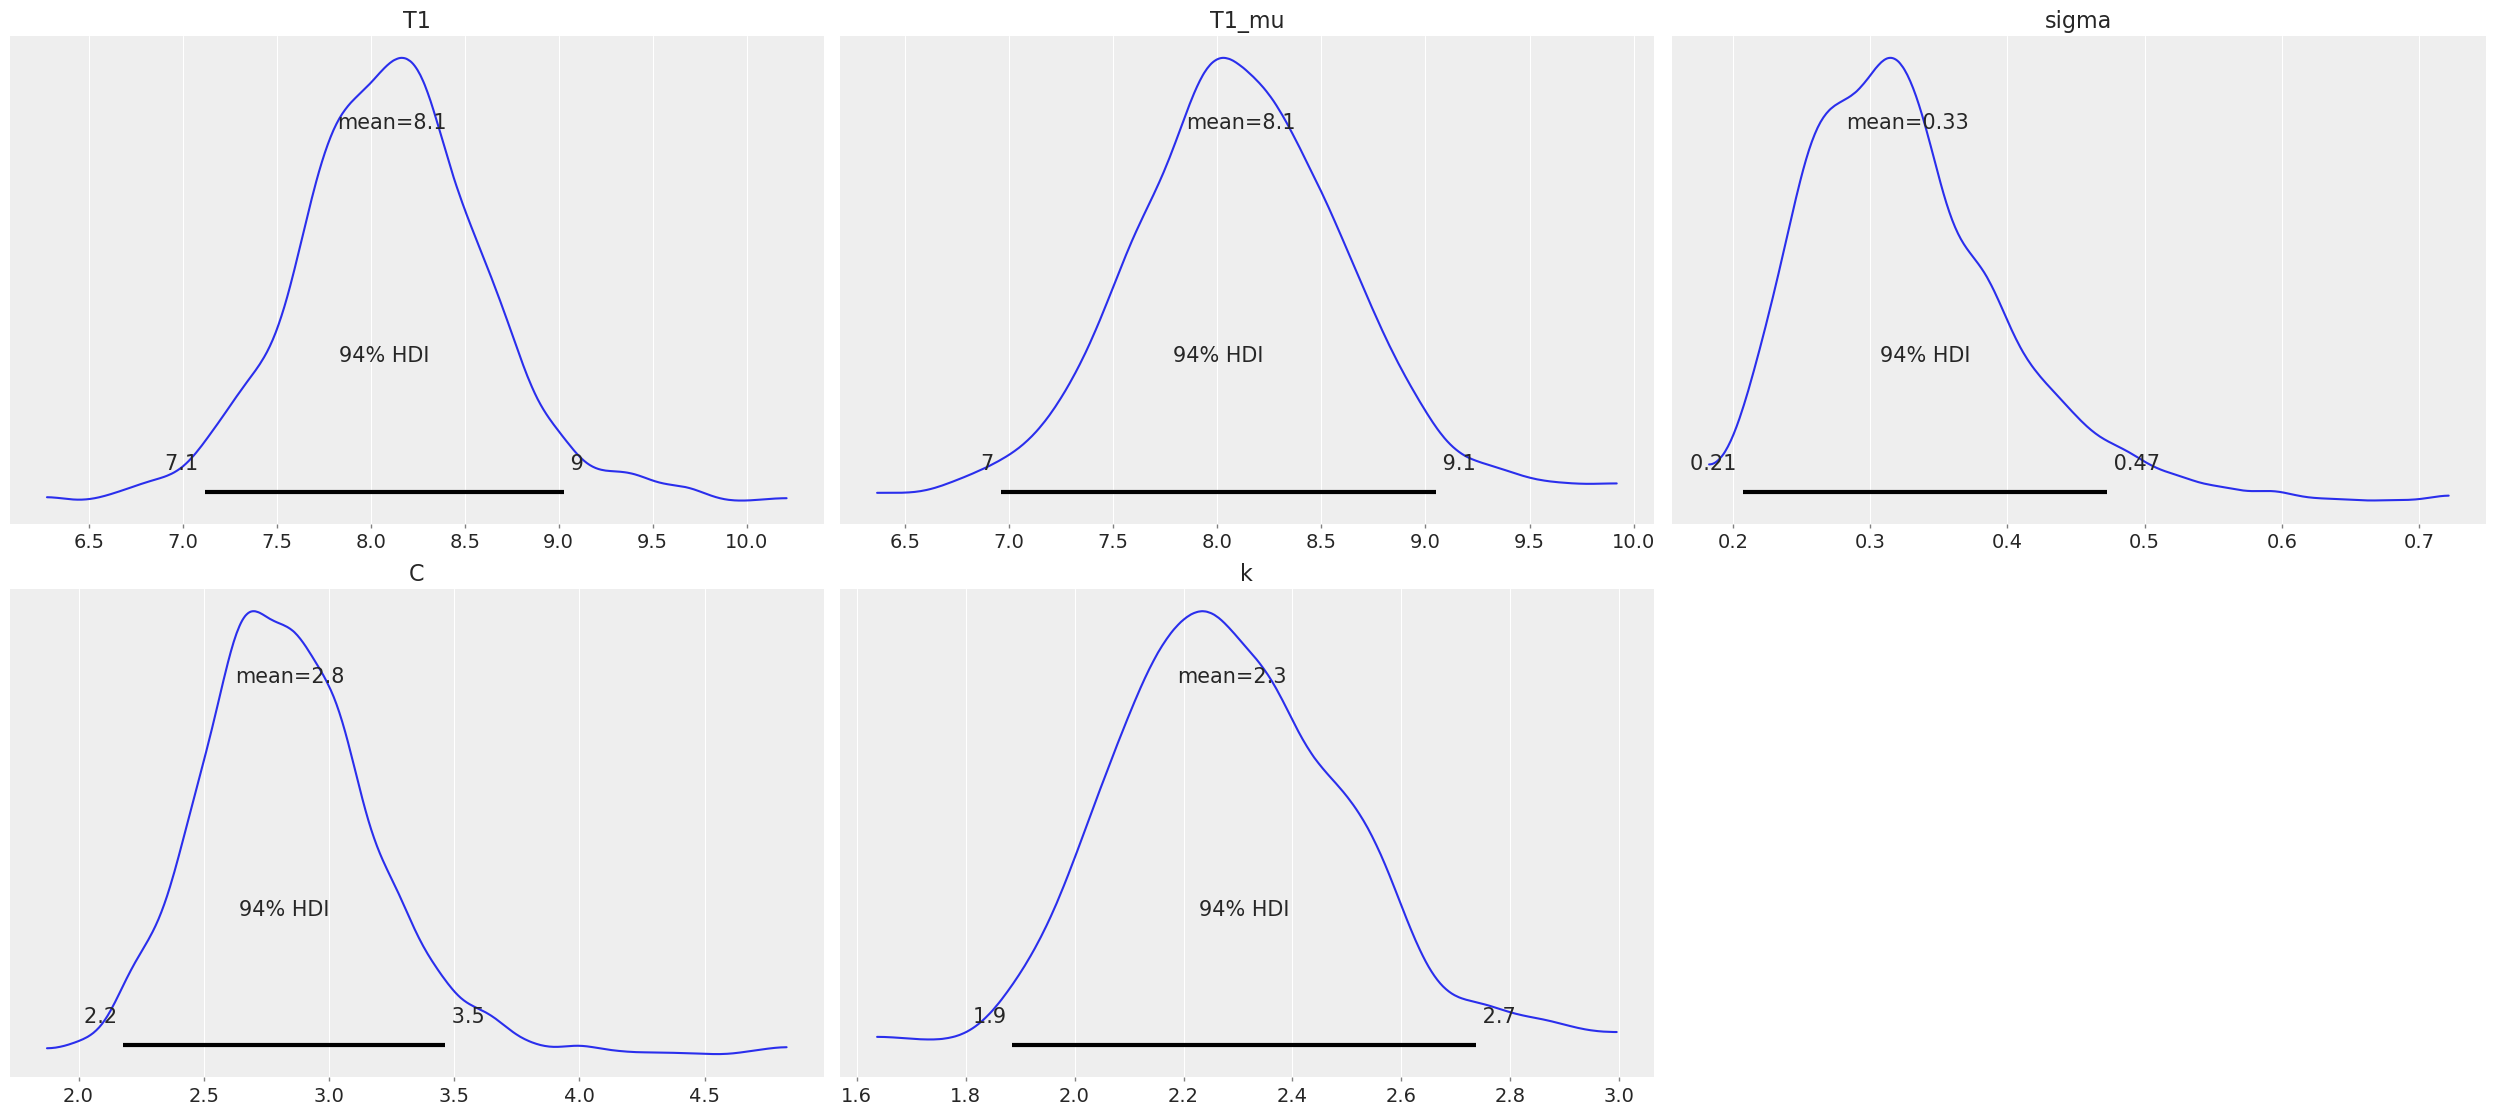

array([[<AxesSubplot: title={'center': 'T1'}>,
        <AxesSubplot: title={'center': 'T1_mu'}>,
        <AxesSubplot: title={'center': 'sigma'}>],
       [<AxesSubplot: title={'center': 'C'}>,
        <AxesSubplot: title={'center': 'k'}>, <AxesSubplot: >]],
      dtype=object)

In [ ]:
az.plot_posterior(idata, show=True)

## What if we use the inverted signals?

In [ ]:
# now with x and y normalized
#x_norm = x/200
y_invert_norm = y_zero_abs_invert/100
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors, here T1 is also scaled down with the same mutiplier of x_norm
    T1_mu = Uniform('T1_mu', 1,10)
    sigma = InverseGamma("sigma", 0.001,0.001)
    C = Uniform("C", lower = 0.1, upper = 5)
    k = Uniform("k", lower = 1, upper = 3)
    T1 = Normal("T1", T1_mu, sigma = 0.2)
    
    
    # Define likelihood
    likelihood = Normal("y", mu=C*(1 - k*np.exp(-1*x_norm*(k - 1)/T1)), sigma=sigma, observed=y_invert_norm)

    # Inference!
    # draw 2000 posterior samples using NUTS sampling
    idata_invert = sample(tune = 1500, draws = 1000, chains = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [T1_mu, sigma, C, k, T1]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 29 seconds.


array([[<AxesSubplot: title={'center': 'T1'}>,
        <AxesSubplot: title={'center': 'T1'}>],
       [<AxesSubplot: title={'center': 'T1_mu'}>,
        <AxesSubplot: title={'center': 'T1_mu'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>],
       [<AxesSubplot: title={'center': 'C'}>,
        <AxesSubplot: title={'center': 'C'}>],
       [<AxesSubplot: title={'center': 'k'}>,
        <AxesSubplot: title={'center': 'k'}>]], dtype=object)

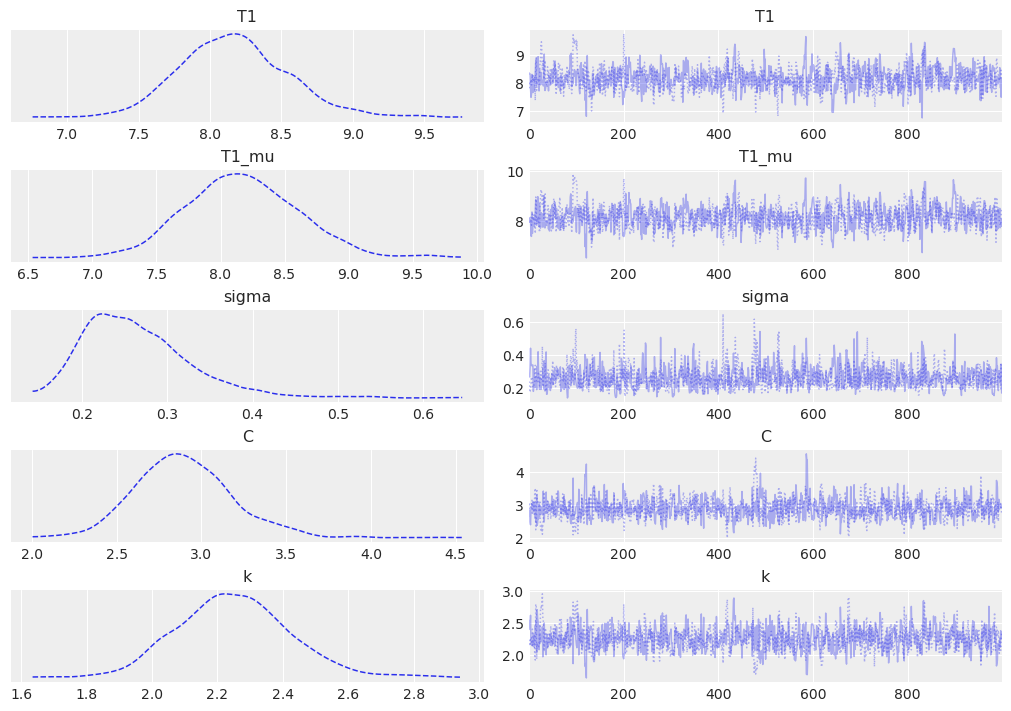

In [ ]:
az.plot_trace(idata_invert, figsize=(10, 7), combined = True)

In [ ]:
print(idata_invert['posterior']['T1'].mean(), idata_invert['posterior']['T1'].std())
print(200 * idata_invert['posterior']['T1'].mean(), 200* idata_invert['posterior']['T1'].std())
p_bayes_invert = np.array ([200*idata_invert['posterior']['T1'].mean(),100*idata_invert['posterior']['C'].mean(),idata_invert['posterior']['k'].mean()])


<xarray.DataArray 'T1' ()>
array(8.17223418) <xarray.DataArray 'T1' ()>
array(0.39782881)
<xarray.DataArray 'T1' ()>
array(1634.44683557) <xarray.DataArray 'T1' ()>
array(79.56576244)


# Try T distribution for robust regression?

In [ ]:
# now with x and y normalized
x_norm = x_zero/200
y_stuT = y_zero_abs/100
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors, here T1 is also scaled down with the same mutiplier of x_norm
    T1_mu = Uniform('T1_mu', 1,10)
    sigma = InverseGamma("sigma", 0.001,0.001)
    C = Uniform("C", lower = 0.1, upper = 5)
    k = Uniform("k", lower = 1, upper = 3)
    T1 = Normal("T1", T1_mu, sigma = 0.2)
    
    # Define likelihood
    likelihood = StudentT("y", mu=np.abs(C*(1 - k*np.exp(-1*x_norm*(k - 1)/T1))), sigma=sigma, nu= 3, observed=y_stuT)

    # Inference!
    # draw 2000 posterior samples using NUTS sampling
    idata_stuT = sample(tune = 1500, draws = 1000, chains = 2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [T1_mu, sigma, C, k, T1]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 30 seconds.


array([[<AxesSubplot: title={'center': 'T1'}>,
        <AxesSubplot: title={'center': 'T1'}>],
       [<AxesSubplot: title={'center': 'T1_mu'}>,
        <AxesSubplot: title={'center': 'T1_mu'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>],
       [<AxesSubplot: title={'center': 'C'}>,
        <AxesSubplot: title={'center': 'C'}>],
       [<AxesSubplot: title={'center': 'k'}>,
        <AxesSubplot: title={'center': 'k'}>]], dtype=object)

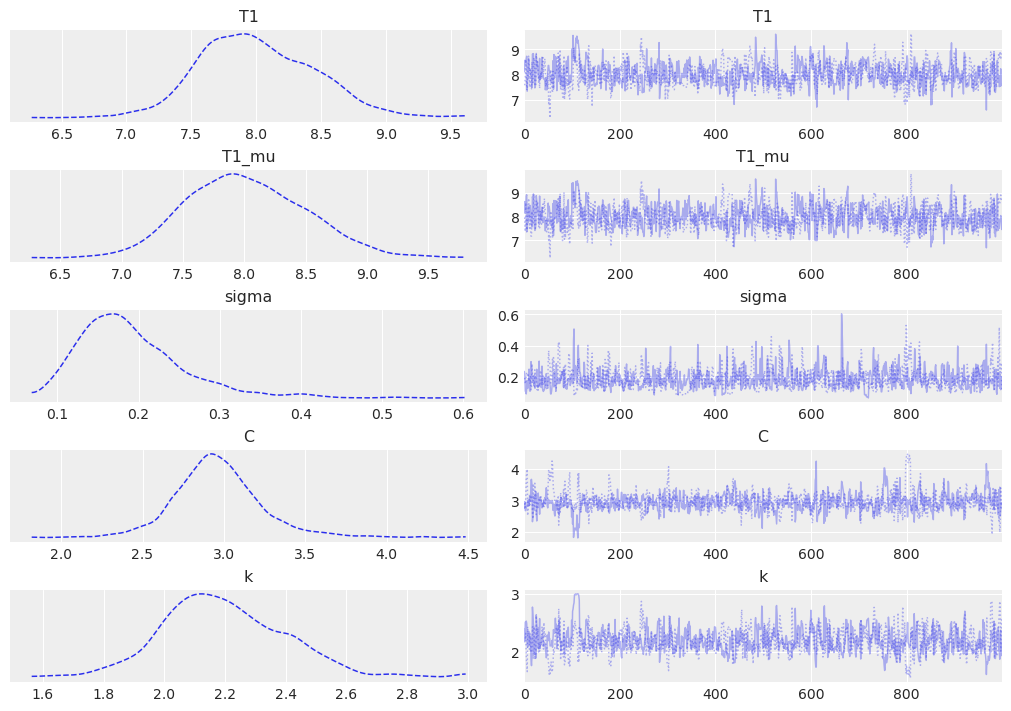

In [ ]:
az.plot_trace(idata_stuT, figsize=(10, 7), combined = True)

In [ ]:
print(idata_stuT['posterior']['T1'].mean(), idata_stuT['posterior']['T1'].std())
print(200 * idata_stuT['posterior']['T1'].mean(), 200* idata_stuT['posterior']['T1'].std())
p_bayes_stuT = np.array ([200*idata_stuT['posterior']['T1'].mean(),100*idata_stuT['posterior']['C'].mean(),idata_stuT['posterior']['k'].mean()])


<xarray.DataArray 'T1' ()>
array(8.01216737) <xarray.DataArray 'T1' ()>
array(0.44807476)
<xarray.DataArray 'T1' ()>
array(1602.43347373) <xarray.DataArray 'T1' ()>
array(89.61495221)


## Plotting - Bayesian and LS via trial

In [ ]:
x_plot_bayes = np.linspace(x.min(), x.max(), 100)
T1,C,k = p_bayes # 
y_plot_bayes = np.abs(C*(1 - k*np.exp(-1*x_plot_bayes*(k - 1)/T1)))
T1,C,k = p_bayes_invert
y_plot_bayes_invert = C*(1 - k*np.exp(-1*x_plot_bayes*(k - 1)/T1))
T1,C,k = p_bayes_stuT
y_plot_bayes_stuT = np.abs(C*(1 - k*np.exp(-1*x_plot_bayes*(k - 1)/T1)))



In [ ]:
res = polarity_recovery(yr, x, p0=None, signal_threshold=25,
                      cache=None, cache_result=True, method="trf",
                                           bounds=(0, (y.max() * 4., 15., 5e3)), # 0 < A < max(s) * 4, 0 < B < max(s) * 8, 0 < T1 < 5000
                                           max_nfev=5000)

p_opt_r = res['p_opt']
null_index_r = res['null_index']

In [ ]:
y_plot_registered = T1_3param(x_plot, p_opt_r[0], p_opt_r[1],p_opt_r[2])

In [ ]:
p_opt,p_opt_zero,p_opt_zero_abs

(array([ 277.98927544,    2.29157083, 1561.74398223]),
 array([ 273.67320448,    2.32187743, 1583.00916627]),
 array([ 288.64510798,    2.24161912, 1629.92974054]))

In [ ]:
p_bayes[0],p_bayes_invert[0],p_bayes_stuT[0]

(1622.3648778814731, 1634.4468355659628, 1602.4334737260233)

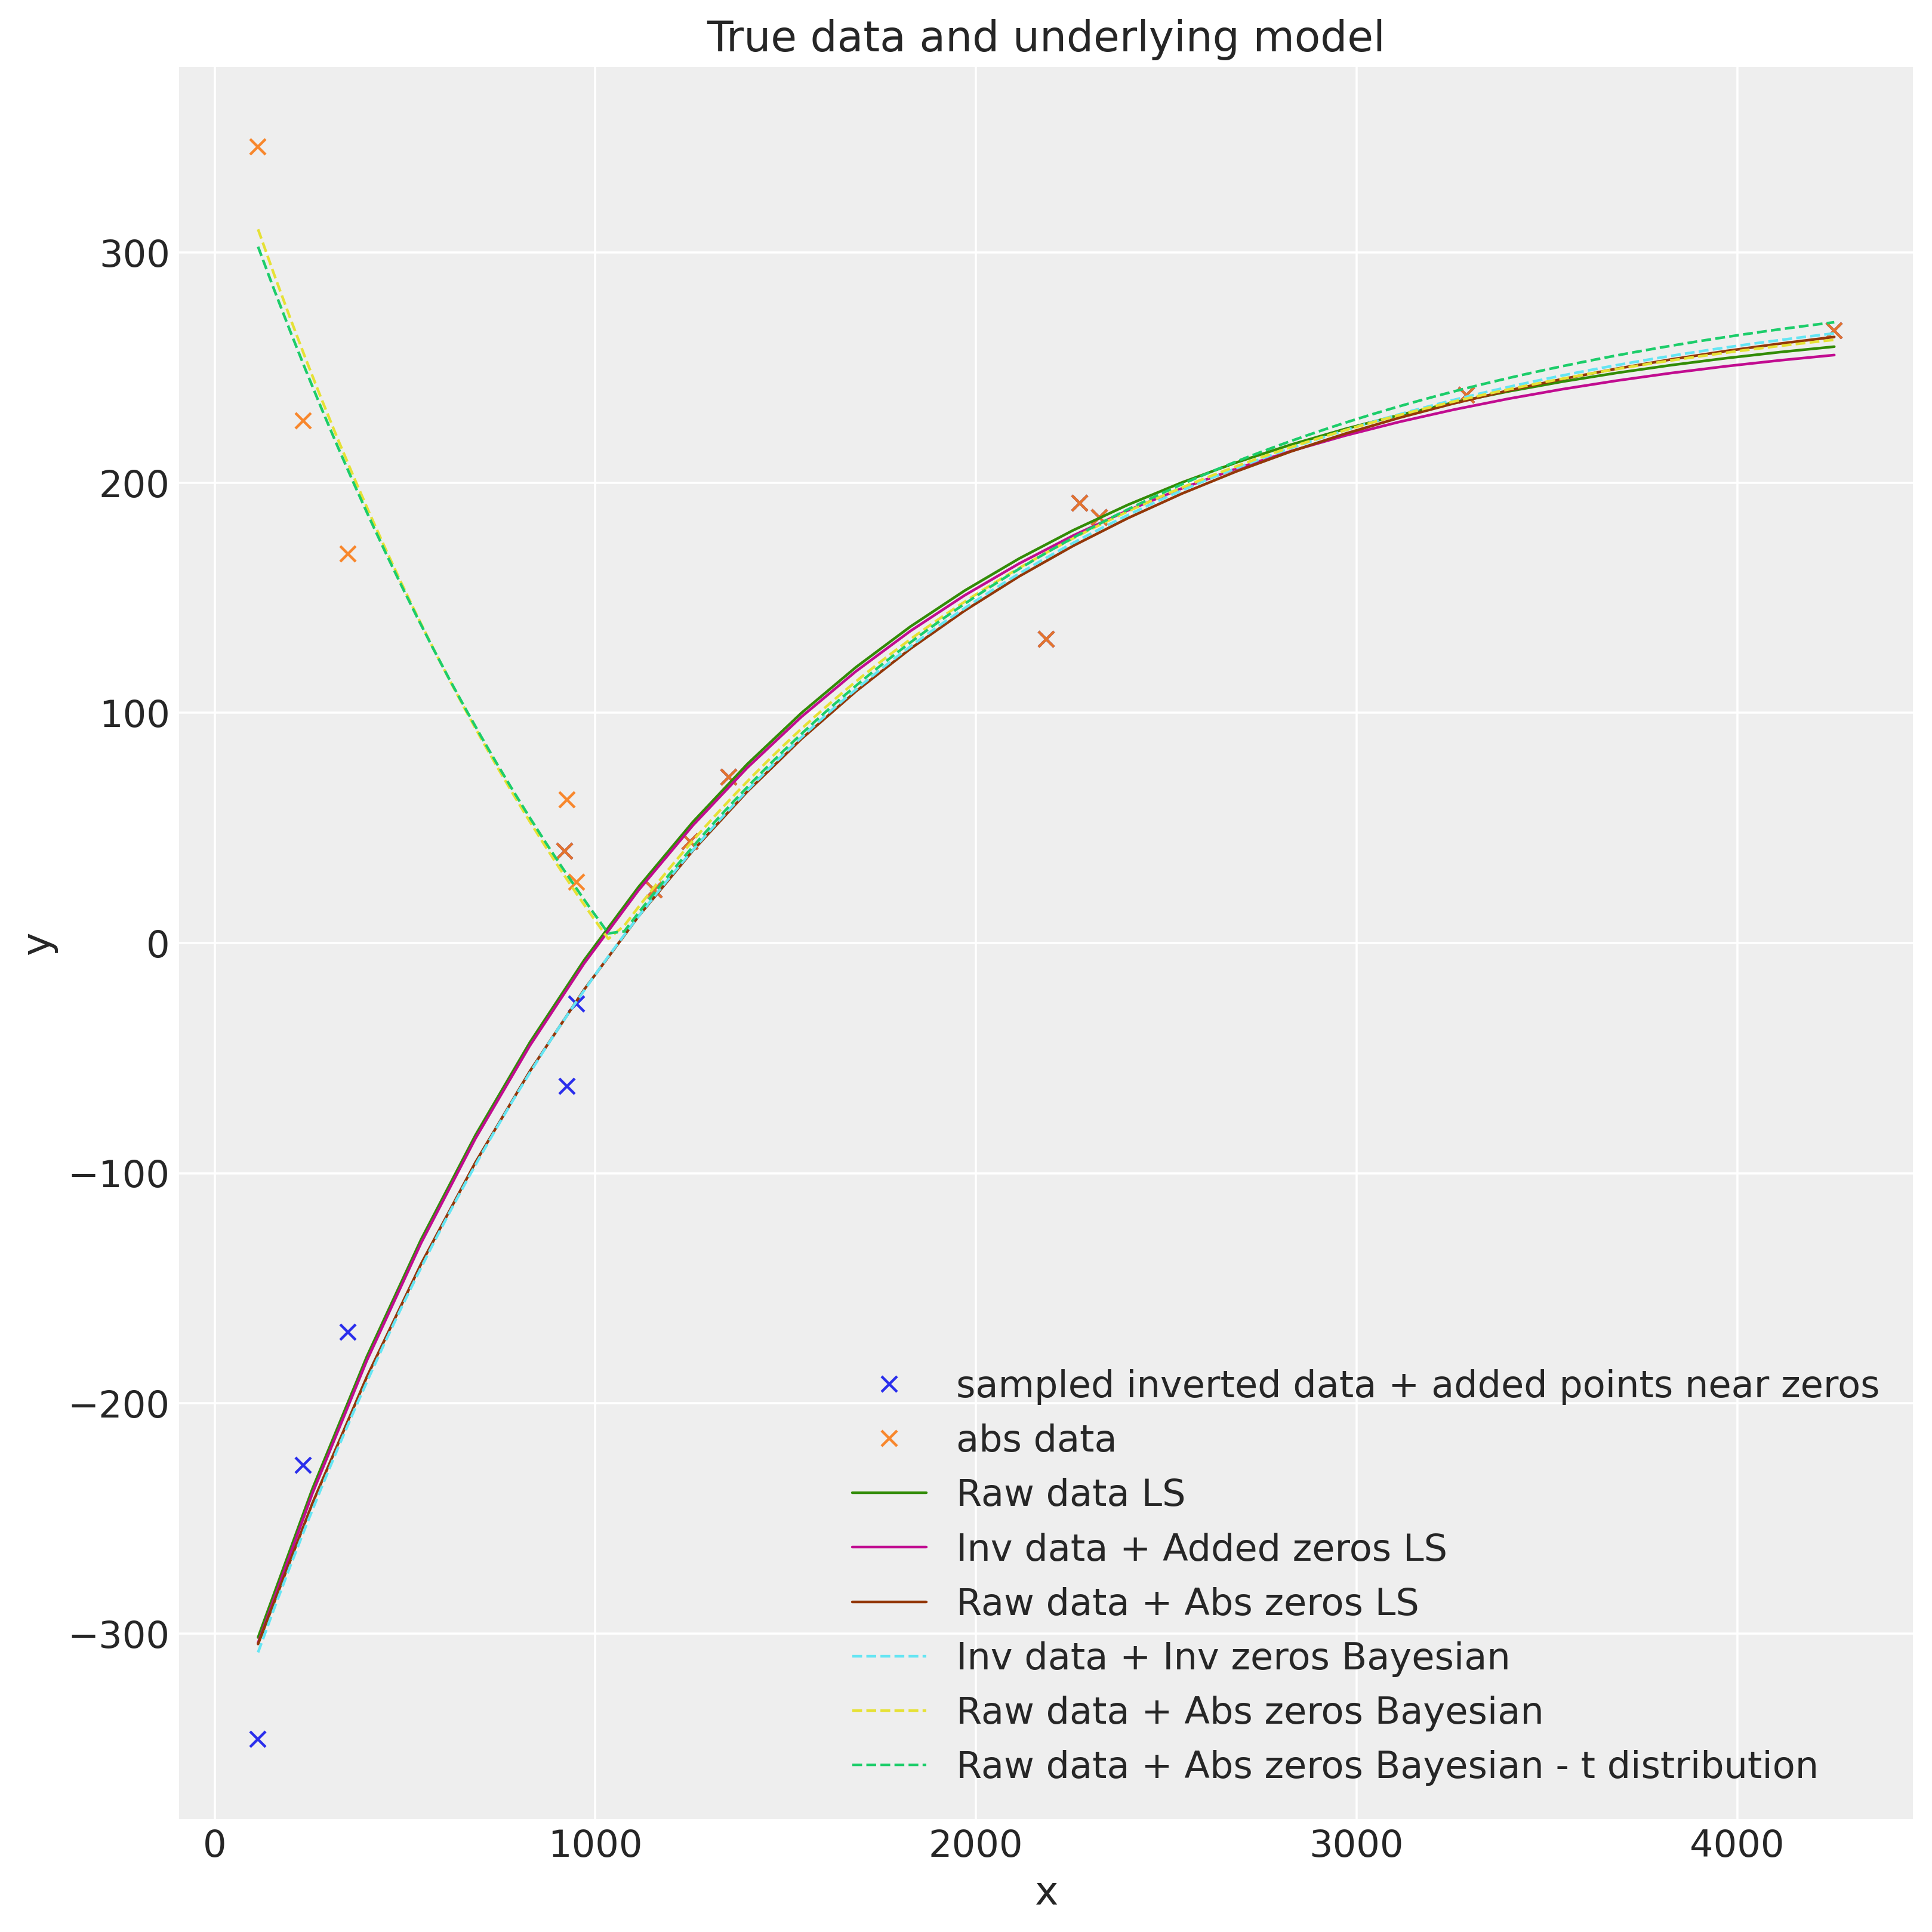

In [ ]:
fig = plt.figure(figsize=(10, 10), dpi = 320)
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="True data and underlying model")
ax.grid(True)
ax.plot(x_zero, y_zero, "x", label="sampled inverted data + added points near zeros")
ax.plot(x_zero, y_zero_abs, "x", label="abs data", alpha = 0.9)

ax.plot(x_plot, y_plot, label="Raw data LS ", lw=1.0)
ax.plot(x_zero_plot, y_zero_plot, label="Inv data + Added zeros LS", lw=1.0)
ax.plot(x_zero_abs_plot, y_zero_abs_plot, label="Raw data + Abs zeros LS", lw=1.0)
ax.plot(x_plot_bayes, y_plot_bayes_invert, label="Inv data + Inv zeros Bayesian", ls = 'dashed',  lw=1)
ax.plot(x_plot_bayes, y_plot_bayes, label="Raw data + Abs zeros Bayesian",ls= 'dashed', lw = 1)

ax.plot(x_plot_bayes, y_plot_bayes_stuT, label="Raw data + Abs zeros Bayesian - t distribution", ls = 'dashed',  lw=1)


plt.legend(loc=0)

## A quick table

# Need Revision here

In [ ]:
# load data from matrix 
base = Path(r"./")
data = loadmat_wrapper_Yi('MAVI102_20151026_pre1.mat')

volume = data["volume"]
tvec = data["tvec"]
#pmap_mse = data["pmap_mse"] 
#null_index = data["null_index"]

# convert pmap_mse, pmap_mse was using s(t) = c * (1 - k * exp(-t/T1*))
# therefore, A = c, B = c * k, T1* remains the same
#pmap_mse[..., 1] = pmap_mse[..., 1] * pmap_mse[..., 0]

# set the rectangular area with already estimated T1* as True. Note that R^(N, 1) x R^(1, N) yields R^[N, N]
# the matrix should be rank 1 and can be represented as the outer product of two vectors
#results_present = (pmap_mse[..., -1].sum(axis=1, keepdims=True) > 0) @  (pmap_mse[..., -1].sum(axis=0, keepdims=True)  > 0)

# for a quick test, choose a few rows only 
#slicer = slice(0, 10, 1)
#volume = volume[slicer]
#pmap_mse = pmap_mse[slicer]
#null_index = null_index[slicer]
#results_present = results_present[slicer]

In [ ]:
volume.shape

(125, 125, 11)

In [ ]:

cpu_cores = os.cpu_count()
pool = Pool(4) 
print(f"Using {cpu_cores:d} cores")

# skip voxels for which we already have the results
results = polarity_recovery_volume(volume, tvec,
                                   do_fitting_mask=None,
                                   pool=pool
                                  )
pool.close()

estimated = results["p_opt"]
sd = results['sd']
#estimated[results_present, ...] = pmap_mse[results_present, ...]
#T1_combined = estimated[..., 2] * (estimated[..., 1] / (estimated[..., 0] + 1e-12) - 1)


Using 20 cores


In [ ]:
print("Using 1 core")

# skip voxels for which we already have the results
results = polarity_recovery_volume(volume, tvec,
                                   do_fitting_mask=None,
                                   pool=None
                                  )

estimated = results["p_opt"]
sd = results['sd']
#estimated[results_present, ...] = pmap_mse[results_present, ...]
#T1_combined = estimated[..., 2] * (estimated[..., 1] / (estimated[..., 0] + 1e-12) - 1)

Using 1 core
start fitting.


C:\Users\white\AppData\Local\Temp\ipykernel_17544\82661194.py:18: RuntimeWarning: overflow encountered in exp
  return C*(1 - k * np.exp(-t*(k-1)/T1))


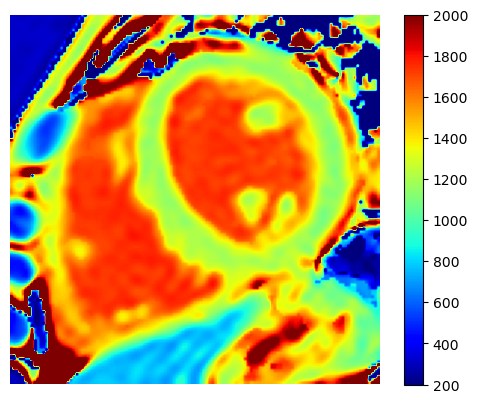

In [ ]:
fig, axes = plt.subplots(dpi=100)
im = axes.imshow(estimated[:,:,2], vmin=200, vmax=2e3, cmap='jet')
axes.axis('off')
plt.colorbar(im)
plt.show()
#plt.close()

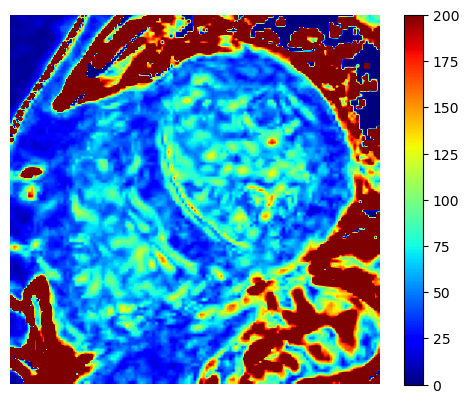

In [ ]:
fig, axes = plt.subplots(dpi=100)
im = axes.imshow(sd[:,:], vmin=0, vmax=200, cmap='jet')
axes.axis('off')

plt.colorbar(im)
plt.show()
plt.close()

In [ ]:
np.save('estimated_ls.npy', estimated)

In [ ]:
np.save('sd_ls.npy', sd)

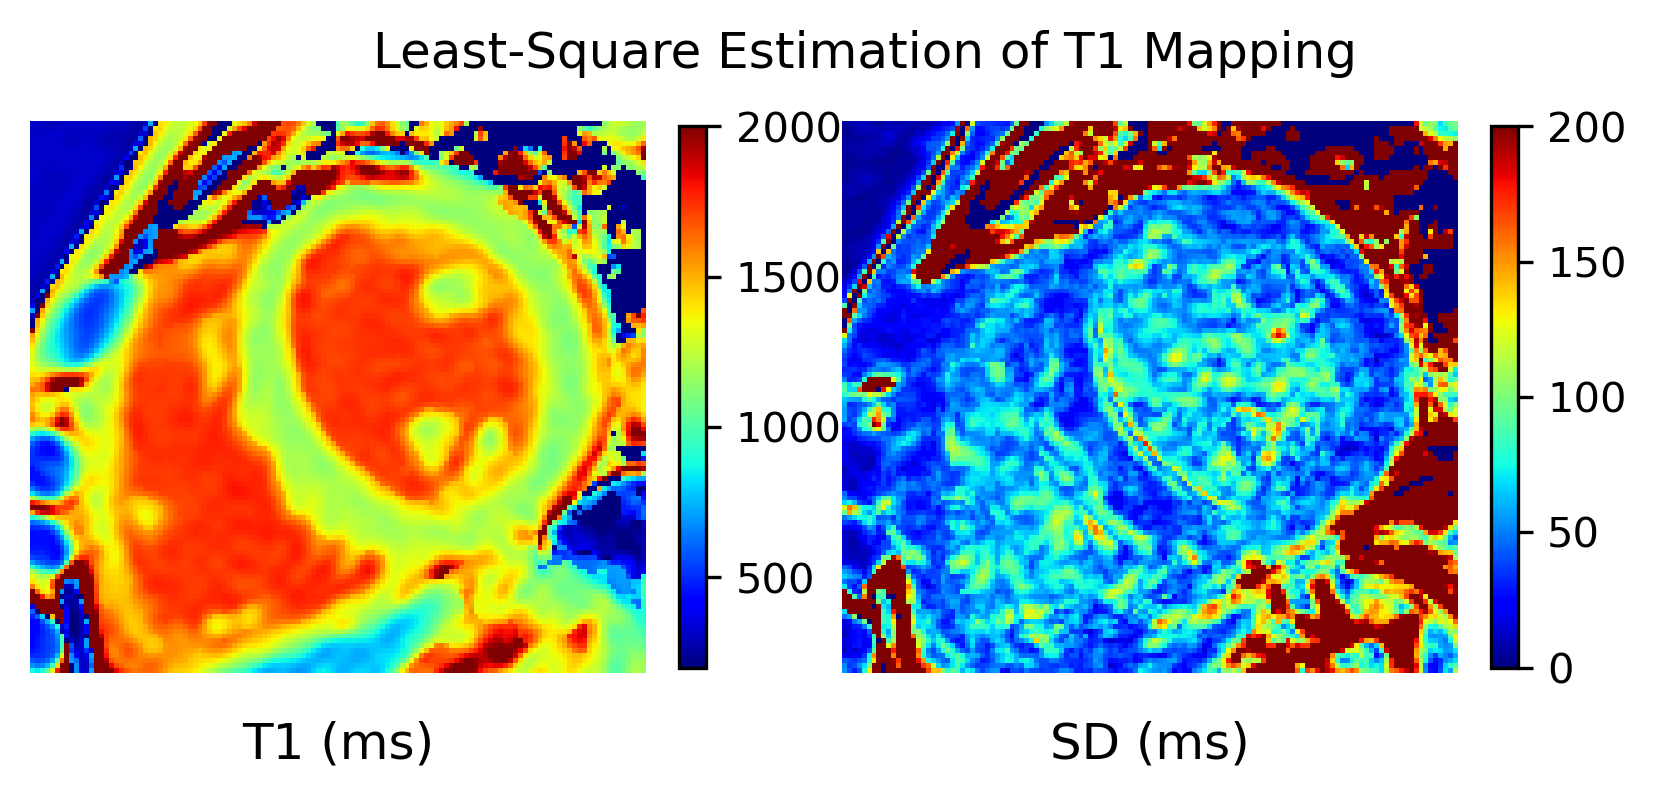

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, dpi=300)
fig.suptitle('Least-Square Estimation of T1 Mapping', x = 0.56, y = 0.75)
im = ax1.imshow(estimated[:112,:,2], vmin=200, vmax=2e3, cmap='jet')
ax1.set_title('T1 (ms)', y = -0.2)
ax1.axis('off')

plt.colorbar(im, fraction=0.040, pad=0.05)

im = ax2.imshow(sd[:112,:], vmin=0, vmax=200, cmap='jet')
ax2.axis('off')
ax2.set_title('SD (ms)', y = -0.2)
plt.colorbar(im, fraction=0.040, pad=0.05)
plt.show()
plt.close()

In [ ]:
sd.max()

923583.7125230284

In [ ]:
sd[:112].shape

(112, 125)

In [ ]:
sd_resize = np.resize(sd[:112], [125*112])

Text(0.5, 1.0, 'Least-Square SD values')

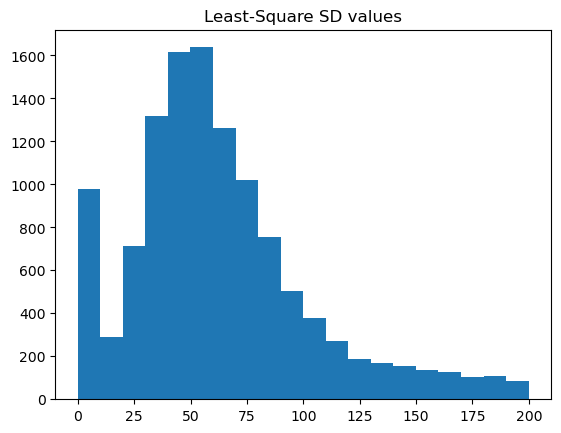

In [ ]:
plt.hist(sd_resize[sd_resize <= 200], bins = 20)
plt.title('Least-Square SD values')

In [ ]:
sd_resize[sd_resize<=200].mean()

62.6127369539071